In [1]:
from data_model import *
from shortest_path import *

In [2]:
# Load data_model, create and dump if new city
data_model = DataModel()

Loaded graph for Amherst, MA from dump


In [3]:
# Print num_nodes, num_edges
data_model.get_stats()

(6202, 17108)

In [4]:
# Routing Algorithm

In [ ]:
router = Routing(data_model)
best_len, best_elv, best_path = router.get_shortest_path()

KeyError: 0

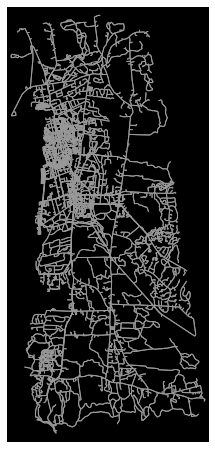

In [9]:
router.plot_route(best_path)

In [6]:
G = data_model.get_graph()

In [7]:
from scipy.optimize import minimize, minimize_scalar
import time

In [8]:
def f(x):
    return x**2

In [9]:
s = time.time()
minimize(f, 9)
print(time.time() - s)

0.001010894775390625


In [10]:
s = time.time()
a = minimize_scalar(f, method='bounded', bounds = [0,1])
print(time.time() - s)
print(a)

0.0022509098052978516
     fun: 3.5531863700963593e-11
 message: 'Solution found.'
    nfev: 25
  status: 0
 success: True
       x: 5.9608609865491405e-06


In [11]:
start_loc=(42.35042, -72.52712)
end_loc=(42.40791, -72.53425)

start = ox.get_nearest_node(G, start_loc)
end = ox.get_nearest_node(G, end_loc)

In [12]:
def minimize_elevation_gain_linear(graph, source, target, percent_shortest_path, iterations=10):
    """
    Minimizes grade gain within constraint of x% of the shortest path by 
    performing a linear search over alpha(between 1.0 and 0.0) such that each 
    iteration calculates a new weight for every edge as the linear combination
    of alpha * normalized distance + (1 - alpha) * normalized grade gain, 
    and finds the resulting shortest weighted path. This algorithm samples 
    evenly across alpha interations number of times instead of limiting the 
    search space like the binary search; it is mainly here to compare against 
    the binary method

    Parameters:
    -----------
    graph: NetworkX MultiDiGraph
        The graph to perform the search on.
    source: int
        The node id of the source point.
    target: int
        The node id of the target point.
    percent_shortest_path: float (> 1.0)
        The constraint of the maximum distance allowed, represented as a 
        percentage of the shorted distance path (1.0 = 100%).
    iterations: int
        The maximum number of iterations of the linear search to perform, at 
        which point the algorithm will return the best path found thus far. 
        The default here is 10, which was found to be a decent trade-off 
        between runtime and result performance.

    Returns: 
    --------
    best_path_dist: float
        The total distance of the best path found
    best_path_gain: float
        The total grade gain of the best path found
    best_edge_path: list of (int, int, int)
        Each tuple (u, v, key) in the list represents an edge in the graph:
        graph[u][v][key]. The resulting list of edges is the best path found to
        minimize grade gain given the constraint        
    """

    # Enforce x% of shortest path 1.0 or larger
    if percent_shortest_path < 1.0:
        raise Exception("Cannot find a path shorter than the shortest path.")

    # Find shortest distance path
    min_dist, min_dist_path = nx.single_source_dijkstra(graph, source, target, weight='length')
    _, min_dist_grade, min_dist_keys = find_path_edges(graph, min_dist_path, min_weight='length')
    # Set maximum distance willing to travel
    max_dist = min_dist * percent_shortest_path

    # Find total distance and grade gain of the edges for normalization
    total_dist = 0
    total_grade = 0
    for u, v, data in graph.edges(data=True):
        total_dist += data['length']
        total_grade += data['grade']

    # Linear combination: alpha * grade + (1 - alpha) * length
    # Start at 1 to see if min grade gain is within max distance
    alpha = 1

    # Dictionary for all paths found within max distance
    paths_found = [{'path': min_dist_path, 'length': min_dist,
                    'grade': min_dist_grade, 'keys': min_dist_keys}]

    # Linear search for 'iterations' iterations, decreasing alpha with step 
    # size alpha/iterations to evenly sample between 0 and 1. If the path is
    # shorter than the maximum distance, save it, and select the shortest
    # grade gain among all paths saved
    for _ in range(iterations):
        print(alpha)
        
        # Create new grades based on binary search of linear combination
        # of normalized distances and grade gains
        for u, v, k, data in graph.edges(keys=True, data=True):
#                 print(alpha*data['grade']/total_grade +
#                               (1-alpha)*data['length']/total_dist, data['grade'], data['length'], total_dist, total_grade )
                graph.add_edge(u, v, key = k, grade = 
                              alpha*data['grade'] +
                              (1-alpha)*data['length'])

        # Find shortest path for new grade
        path = nx.shortest_path(graph, source, target, weight='grade')
        path_length, path_grade, path_keys = find_path_edges(graph, path)

        ############################################
        # Uncomment to view each iteration         #
        #                                          #
        #print(alpha, path_grade, path_length)  #
        #                                          #
        ############################################

        # If the path found has a shorter distance than the max, 
        if path_length <= max_dist:            
            # Add it to the list of paths to pick from
            paths_found.append({'path': path, 'length': path_length, 
                                'grade': path_grade, 'keys': path_keys})

            # If the min grade gain path is within the max distance
            # the best path already found, break out early
            if alpha == 1.0:
                break            
        # linear search over alpha
        alpha = alpha - (alpha / iterations)


    # Return the lowest grade gain within max distance
    best_path = min(paths_found, key=lambda d: d['grade'])
    best_path_dist = best_path['length']
    best_path_gain = best_path['grade']

    return (best_path_dist, best_path_gain)


In [13]:
def minimize_elevation_gain_linear(graph, source, target, percent_shortest_path, iterations=10):
    """
    Minimizes grade gain within constraint of x% of the shortest path by 
    performing a linear search over alpha(between 1.0 and 0.0) such that each 
    iteration calculates a new weight for every edge as the linear combination
    of alpha * normalized distance + (1 - alpha) * normalized grade gain, 
    and finds the resulting shortest weighted path. This algorithm samples 
    evenly across alpha interations number of times instead of limiting the 
    search space like the binary search; it is mainly here to compare against 
    the binary method

    Parameters:
    -----------
    graph: NetworkX MultiDiGraph
        The graph to perform the search on.
    source: int
        The node id of the source point.
    target: int
        The node id of the target point.
    percent_shortest_path: float (> 1.0)
        The constraint of the maximum distance allowed, represented as a 
        percentage of the shorted distance path (1.0 = 100%).
    iterations: int
        The maximum number of iterations of the linear search to perform, at 
        which point the algorithm will return the best path found thus far. 
        The default here is 10, which was found to be a decent trade-off 
        between runtime and result performance.

    Returns: 
    --------
    best_path_dist: float
        The total distance of the best path found
    best_path_gain: float
        The total grade gain of the best path found
    best_edge_path: list of (int, int, int)
        Each tuple (u, v, key) in the list represents an edge in the graph:
        graph[u][v][key]. The resulting list of edges is the best path found to
        minimize grade gain given the constraint        
    """

    # Enforce x% of shortest path 1.0 or larger
    if percent_shortest_path < 1.0:
        raise Exception("Cannot find a path shorter than the shortest path.")

    # Find shortest distance path
    min_dist, min_dist_path = nx.single_source_dijkstra(graph, source, target, weight='length')
    _, min_dist_grade, min_dist_keys = find_path_edges(graph, min_dist_path, min_weight='length')
    # Set maximum distance willing to travel
    max_dist = min_dist * percent_shortest_path

    # Find total distance and grade gain of the edges for normalization
    total_dist = 0
    total_grade = 0
    for u, v, data in graph.edges(data=True):
        total_dist += data['length']
        total_grade += data['grade']

    # Linear combination: alpha * grade + (1 - alpha) * length
    # Start at 1 to see if min grade gain is within max distance
    alpha = 0.9

    # Dictionary for all paths found within max distance
    paths_found = [{'path': min_dist_path, 'length': min_dist,
                    'grade': min_dist_grade, 'keys': min_dist_keys}]

    # Linear search for 'iterations' iterations, decreasing alpha with step 
    # size alpha/iterations to evenly sample between 0 and 1. If the path is
    # shorter than the maximum distance, save it, and select the shortest
    # grade gain among all paths saved
    
    
    def minimize_alpha(alpha):
        print(alpha)
        # Create new grades based on binary search of linear combination
        # of normalized distances and grade gains
        for u, v, k, data in graph.edges(keys=True, data=True):
                graph.add_edge(u, v, key = k, grade = 
                              alpha*data['grade'] +
                              (1-alpha)*data['length'])

        # Find shortest path for new grade
        path = nx.shortest_path(graph, source, target, weight='grade')
        path_length, path_grade, path_keys = find_path_edges(graph, path)

        # If the path found has a shorter distance than the max, 
        if path_length <= max_dist:            
            # Add it to the list of paths to pick from
            paths_found.append({'path': path, 'length': path_length, 
                                'grade': path_grade, 'keys': path_keys})
                
        return (max_dist - path_length)**2
    
#     a = minimize_scalar(minimize_alpha)
    a = minimize(minimize_alpha, 1)

    print("ans:", a)
    # Return the lowest grade gain within max distance
    best_path = min(paths_found, key=lambda d: d['grade'])
    best_path_dist = best_path['length']
    best_path_gain = best_path['grade']

    return (best_path_dist, best_path_gain)


In [14]:
s = time.time()
print(minimize_elevation_gain_linear(G, start, end, 1.5))
print(time.time()-s)

[1.]
[1.00000001]
[1.]
ans:       fun: 14225603.967540246
 hess_inv: array([[1]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([1.])
(7543.368999999999, array([7543.36901139]))
0.6832568645477295


In [15]:
def find_path_edges(graph, path, min_weight='grade'):
    """
    Given a path as a list of nodes, and the weight that was used when finding 
    the shortest path, finds the edge that was used to minimize the weight 
    between each node in the list. For convieniece this function returns the 
    length and elevation gain found along all of these edges, in addition to 
    the list of keys that corisponds to these edges.
        
    Parameters:
    -----------
    graph: NetworkX MultiDiGraph
        The graph that this path belongs to.
    path: list of int
        Each int should represent a node id in the graph along a path.
    min_weight: string
        The weight that was minimized when finding this path.
        
    Returns: 
    --------
    path_length: float
        The total distance along every edge found
    path_ele_gain: float
        The total elevation gain along every edge found
    path_edge_keys: list of int
        Each int represents the key of the edge between two consecutive nodes 
        in path which minimizes min_weight.        
    """    
    path_length = 0
    path_ele_gain = 0
    path_edge_keys = []
    for i in range(len(path) - 1):
        edges = graph[path[i]][path[i + 1]]
        min_weight_edge = min(edges.keys(), key=lambda k: edges[k][min_weight])
        path_length += edges[min_weight_edge]['length']
        path_ele_gain += edges[min_weight_edge]['grade']
        path_edge_keys.append(min_weight_edge)
    return (path_length, path_ele_gain, path_edge_keys)

In [16]:
G.nodes[61722375]

{'y': 42.307596, 'x': -72.470723, 'osmid': 61722375, 'elevation': 118.27}